In [73]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='5f56bbed-3fef-4cf8-98a5-4259d0bc907f', project_access_token='p-73259bd7c2a5cf6b70b5125162b670774f4c9e00')
pc = project.project_context


In [4]:
!pip install spacy -q
!pip install pyLDAvis -q
!pip install gensim -q

In [74]:
import pandas as pd
import nltk
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> 

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Downloader> q


True

In [75]:
my_file = project.get_file('github_comments.tsv')
data = pd.read_csv(my_file,sep='\t',index_col=False)
data.drop(columns=["Unnamed: 0"],inplace=True)

In [76]:
data.shape

(4001, 5)

In [77]:
data.head()

,comment,comment_date,is_merged,merged_at,request_changes
0,@chef/maintainers,2017-05-29 10:54:23,0.0,NaN,0
1,omnibus builds are already in pain so merging ...,2017-05-25 20:34:45,1.0,2017-05-25 20:34:27,0
2,@chef/client-core reviewage (lets not think to...,2017-05-25 17:21:56,1.0,2017-05-25 19:05:10,0
3,This blows up 14.04 because allow-downgrades i...,2017-05-25 19:15:14,0.0,NaN,1
4,I know @lamont-granquist and @thommay are goi...,2017-05-23 22:58:13,1.0,2017-05-24 04:40:42,0


Removing name mentions, punctuations, stop words, numbers  from the data since they dont add any value to the context of the comment

In [78]:
data['cleaned'] = data['comment'].str.replace('@([A-Za-z0-9-/]+)','')

In [79]:
stop_words = nltk.corpus.stopwords.words('english')

In [80]:
data['cleaned'] = data['cleaned'].str.replace("[^a-zA-Z#]", " ")
data['cleaned'] = data['cleaned'].apply(lambda x: [word for word in x.split() if len(word)>2])
data['cleaned'] = data['cleaned'].apply(lambda x: [word.lower() for word in x if word not in stop_words])

In [81]:
data.head()

,comment,comment_date,is_merged,merged_at,request_changes,cleaned
0,@chef/maintainers,2017-05-29 10:54:23,0.0,NaN,0,[]
1,omnibus builds are already in pain so merging ...,2017-05-25 20:34:45,1.0,2017-05-25 20:34:27,0,"[omnibus, builds, already, pain, merging, fix]"
2,@chef/client-core reviewage (lets not think to...,2017-05-25 17:21:56,1.0,2017-05-25 19:05:10,0,"[reviewage, lets, think, hard, breakpoint, res..."
3,This blows up 14.04 because allow-downgrades i...,2017-05-25 19:15:14,0.0,NaN,1,"[this, blows, allow, downgrades, supported, ne..."
4,I know @lamont-granquist and @thommay are goi...,2017-05-23 22:58:13,1.0,2017-05-24 04:40:42,0,"[know, going, unhappy, one, this, absolutely, ..."


Inspecting rows where there are no words left after filtering - It seems that these are mostly 'Ok's or '+1's. The rest have no context value.

In [82]:
#data[data['cleaned'].apply(len)==0]
data = data[data['cleaned'].apply(len)!=0]

In [83]:
data.head()

,comment,comment_date,is_merged,merged_at,request_changes,cleaned
1,omnibus builds are already in pain so merging ...,2017-05-25 20:34:45,1.0,2017-05-25 20:34:27,0,"[omnibus, builds, already, pain, merging, fix]"
2,@chef/client-core reviewage (lets not think to...,2017-05-25 17:21:56,1.0,2017-05-25 19:05:10,0,"[reviewage, lets, think, hard, breakpoint, res..."
3,This blows up 14.04 because allow-downgrades i...,2017-05-25 19:15:14,0.0,NaN,1,"[this, blows, allow, downgrades, supported, ne..."
4,I know @lamont-granquist and @thommay are goi...,2017-05-23 22:58:13,1.0,2017-05-24 04:40:42,0,"[know, going, unhappy, one, this, absolutely, ..."
5,"no, that's absolutely the right thing to do.",2017-05-24 13:48:17,1.0,2017-05-24 04:40:42,0,"[absolutely, right, thing]"


Now I try to create a frequencyPlot of all the token to see which words occor the most in all the comment

In [84]:
data['cleaned_list'] = data['cleaned'].apply(lambda x: " ".join(x))

In [85]:
l = []
data['cleaned'].apply(lambda x: [l.append(wlist) for wlist in x])
freq = nltk.FreqDist(l)
words_df = pd.DataFrame({'word':list(freq.keys()), 'count':list(freq.values())})

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


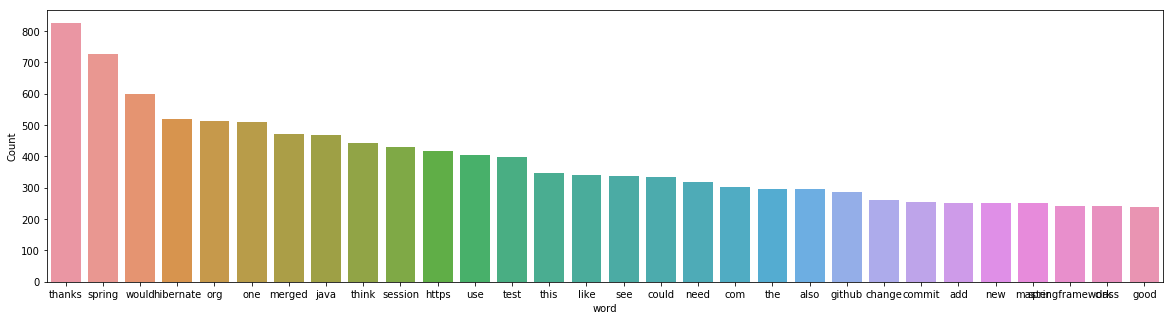

In [86]:
d = words_df.nlargest(columns="count", n = 30) 
plt.figure(figsize=(20,5))
ax = sns.barplot(data=d, x= "word", y = "count")
ax.set(ylabel = 'Count')
plt.show()

It seems like a lot of people are using the word 'thanks' - But that is a fairly common word in any team work setting.

However, the words 'spring','hibernate','java','session','test' should be investigated further. More on that later!!

So now I'll try to convert the corpus into a 1-gram Bag of Words and try to use K-mean clustering to see if that gives neat clusters of the topics

In [87]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(ngram_range = (1,1))
text_counts_1gram = cv.fit_transform(data['cleaned_list'])

In [88]:
X = text_counts_1gram.todense()

In [89]:
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

#Normalizing data
X_scaled = MinMaxScaler().fit_transform(X)

km = KMeans(n_clusters=4,max_iter=9999)

km.fit(X_scaled)

/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=9999,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

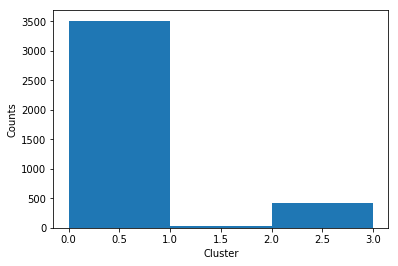

In [90]:
pred = km.predict(X_scaled)
_ = plt.hist(pred,bins= range(0,4))
_ = plt.xlabel('Cluster')
_ = plt.ylabel('Counts')

plt.show()

In [91]:
data['km_cluster']=pred

cluster No = 0, Cluster count = 3512


/opt/conda/envs/DSX-Python35/lib/python3.5/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


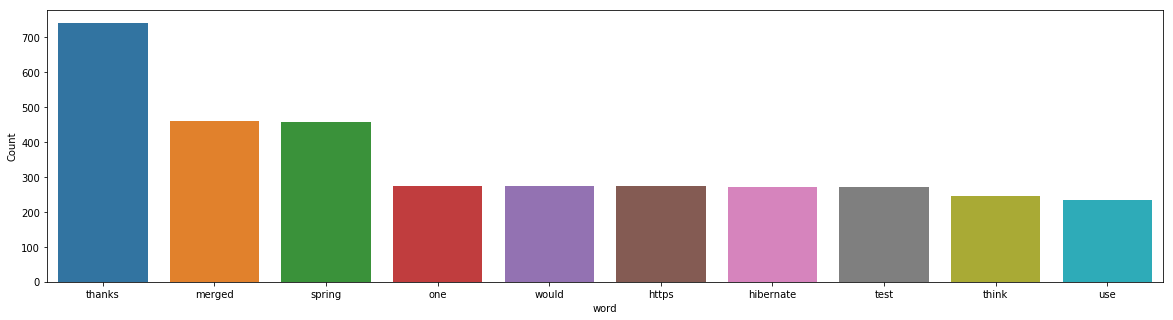

cluster No = 1, Cluster count = 27


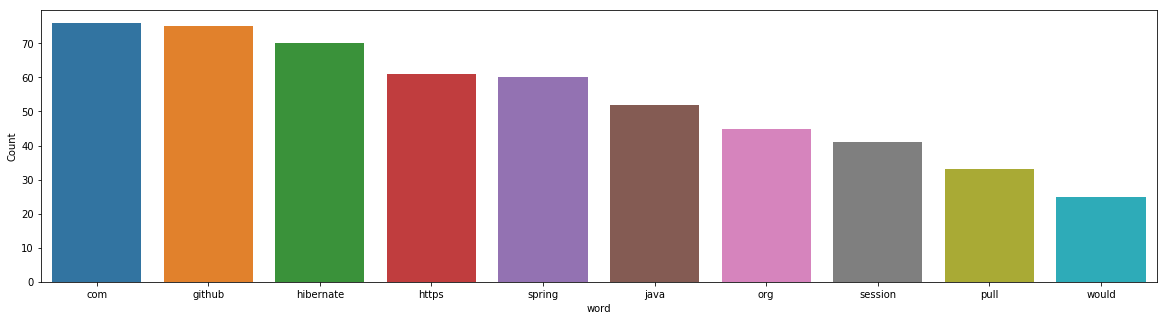

cluster No = 2, Cluster count = 418


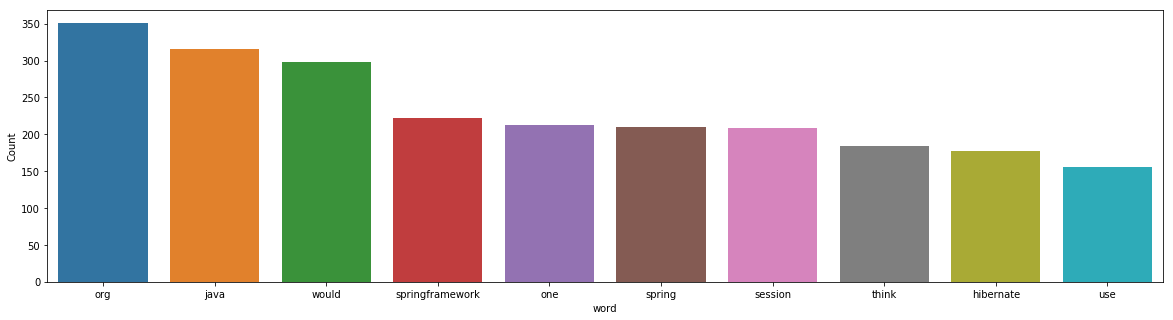

cluster No = 3, Cluster count = 1


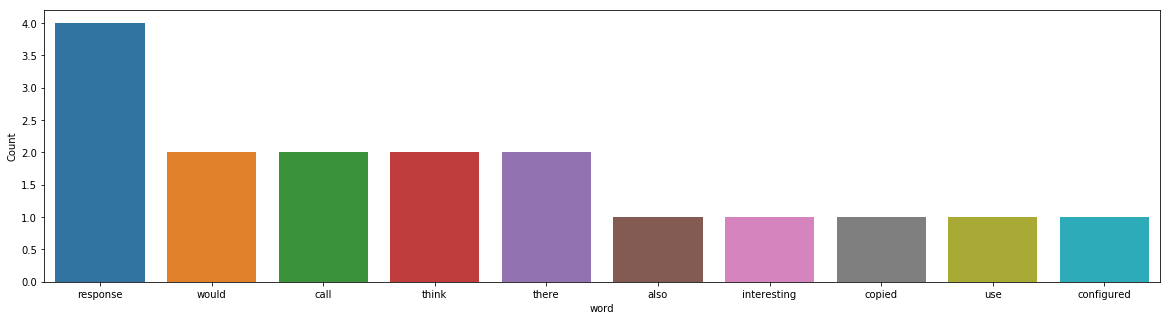

In [92]:
for cluster in set(pred):
    l = []
    data[data['km_cluster']==cluster]['cleaned'].apply(lambda x: [l.append(wlist) for wlist in x])
    freq = nltk.FreqDist(l)
    words_df = pd.DataFrame({'word':list(freq.keys()), 'count':list(freq.values())})
    d = words_df.nlargest(columns="count", n = 10) 
    plt.figure(figsize=(20,5))
    ax = sns.barplot(data=d, x= "word", y = "count")
    ax.set(ylabel = 'Count')
    print('cluster No = {}, Cluster count = {}'.format(cluster,data[data['km_cluster']==cluster].shape[0]))
    plt.show()

As can be seen that the clusters have a very uneven distribution and no clear pattern emerges

I tried various counts of K and different normalization tecniques but in vain

**The word spring appears again though**

So since Kmeans has actually delivered any substantial value I will try to use a more complex but intuitive approach: LDA Model

***LDA***

performing LDA on the 'cleaned' tokens

In [93]:
dictionary = corpora.Dictionary(data['cleaned'])
doc_term_matrix = [dictionary.doc2bow(sent) for sent in data['cleaned']]


In [141]:
LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5,alpha='auto',passes=4)

In [142]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
1      30.853580        1       1 -0.038030 -0.048618
4      22.123337        1       2 -0.021314 -0.116993
2      20.902973        1       3 -0.060081 -0.086990
0      15.210517        1       4  0.253944  0.062840
3      10.909592        1       5 -0.134520  0.189760, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
1524  Default  849.000000           thanks  849.000000  30.0000  30.0000
665   Default  516.000000           merged  516.000000  29.0000  29.0000
928   Default  587.000000           spring  587.000000  28.0000  28.0000
1304  Default  418.000000             java  418.000000  27.0000  27.0000
1046  Default  451.000000              org  451.000000  26.0000  26.0000
1714  Default  510.000000             http  510.000000  25.0000  25.0000
1603  Default  237.000000           master  237.000000  24.0000  24.0000
936   Default  306.000000              com  306.000000  23.0000  23.0000
1627  Default  173.000000             bean  173.000000  22.0000  22.0000
251   Default  293.000000           github  293.000000  21.0000  21.0000
49    Default  175.000000  springframework  175.000000  20.0000  20.0000
1527  Default  218.000000          project  218.000000  19.0000  19.0000
28    Default  209.000000           please  209.000000  18.0000  18.0000
1298  Default  560.000000        hibernate  560.000000  17.0000  17.0000
652   Default  369.000000          session  369.000000  16.0000  16.0000
31    Default  148.000000           string  148.000000  15.0000  15.0000
1217  Default  108.000000          jenkins  108.000000  14.0000  14.0000
551   Default  170.000000             pull  170.000000  13.0000  13.0000
890   Default  114.000000          factory  114.000000  12.0000  12.0000
1606  Default  138.000000    elasticsearch  138.000000  11.0000  11.0000
393   Default   89.000000           retest   89.000000  10.0000  10.0000
72    Default  129.000000          rebased  129.000000   9.0000   9.0000
1704  Default  115.000000              cla  115.000000   8.0000   8.0000
1077  Default  237.000000           search  237.000000   7.0000   7.0000
316   Default  589.000000              one  589.000000   6.0000   6.0000
104   Default  168.000000          support  168.000000   5.0000   5.0000
1620  Default  246.000000             name  246.000000   4.0000   4.0000
1318  Default  124.000000            error  124.000000   3.0000   3.0000
888   Default  190.000000            field  190.000000   2.0000   2.0000
94    Default  592.000000             test  592.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
332    Topic5    5.117751         boosting    6.582002   1.9639  -7.1677
844    Topic5   49.426735         internal   63.596260   1.9635  -4.8999
1259   Topic5   37.062859          private   48.440151   1.9478  -5.1878
883    Topic5   10.810189            inner   14.461466   1.9245  -6.4199
31     Topic5  109.344360           string  148.469070   1.9097  -4.1059
1046   Topic5  317.972748              org  451.207397   1.8656  -3.0384
1709   Topic5   29.728125           import   39.871582   1.9220  -5.4083
1456   Topic5   66.742561           public   97.280411   1.8388  -4.5995
28     Topic5  133.695618           please  209.028107   1.7686  -3.9048
969    Topic5   27.366385           nested   37.761749   1.8935  -5.4911
1520   Topic5   54.182487            group   80.833138   1.8155  -4.8080
1318   Topic5   77.792885            error  124.553650   1.7448  -4.4463
57     Topic5   23.004194             util   31.453154   1.9027  -5.6647
104    Topic5   88.371170          support  168.159576   1.5722  -4.3188
1611   Topic5   24.695709           failed   35.571438   1.8506  -5.5937
1678   Topic5   17.182724          extends   22.993616   1.9242  -5.9565
46

As can be seen that the topic distinction isnt as clear

Some terms with similar meanings appear multiple times like 'test' and 'retest' and 'merge' and 'merged', 'build' and 'builds' etc. Many such examples can be seen in the text.

So I lemmatize the corpus and perfrom LDA again

In [96]:
data['lemmatized'] = data['cleaned'].apply(lambda x: [nltk.WordNetLemmatizer().lemmatize(word) for word in x])

In [97]:
data.head(6)

,comment,comment_date,is_merged,merged_at,request_changes,cleaned,cleaned_list,km_cluster,lemmatized
1,omnibus builds are already in pain so merging ...,2017-05-25 20:34:45,1.0,2017-05-25 20:34:27,0,"[omnibus, builds, already, pain, merging, fix]",omnibus builds already pain merging fix,0,"[omnibus, build, already, pain, merging, fix]"
2,@chef/client-core reviewage (lets not think to...,2017-05-25 17:21:56,1.0,2017-05-25 19:05:10,0,"[reviewage, lets, think, hard, breakpoint, res...",reviewage lets think hard breakpoint resource ...,0,"[reviewage, let, think, hard, breakpoint, reso..."
3,This blows up 14.04 because allow-downgrades i...,2017-05-25 19:15:14,0.0,NaN,1,"[this, blows, allow, downgrades, supported, ne...",this blows allow downgrades supported need fig...,0,"[this, blow, allow, downgrade, supported, need..."
4,I know @lamont-granquist and @thommay are goi...,2017-05-23 22:58:13,1.0,2017-05-24 04:40:42,0,"[know, going, unhappy, one, this, absolutely, ...",know going unhappy one this absolutely short t...,0,"[know, going, unhappy, one, this, absolutely, ..."
5,"no, that's absolutely the right thing to do.",2017-05-24 13:48:17,1.0,2017-05-24 04:40:42,0,"[absolutely, right, thing]",absolutely right thing,0,"[absolutely, right, thing]"
6,^ trailing comma is trolling you,2017-05-23 23:08:46,1.0,2017-05-24 04:40:42,0,"[trailing, comma, trolling]",trailing comma trolling,0,"[trailing, comma, trolling]"


In [139]:
dictionary = corpora.Dictionary(data['lemmatized'])
dictionary.filter_extremes(no_below=5)

doc_term_matrix = [dictionary.doc2bow(sent) for sent in data['lemmatized']]

LDA = gensim.models.ldamodel.LdaModel

lda_model = LDA(corpus=doc_term_matrix, id2word=dictionary, num_topics=5)

In [140]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      31.549797        1       1 -0.035757  0.015671
3      21.329689        1       2 -0.008313  0.009980
1      19.185654        1       3 -0.050283  0.047153
4      15.725286        1       4 -0.010198 -0.092602
0      12.209575        1       5  0.104551  0.019798, topic_info=     Category        Freq             Term       Total  loglift  logprob
term                                                                    
665   Default  394.000000           merged  394.000000  30.0000  30.0000
1524  Default  728.000000           thanks  728.000000  29.0000  29.0000
1298  Default  542.000000        hibernate  542.000000  28.0000  28.0000
1077  Default  234.000000           search  234.000000  27.0000  27.0000
1304  Default  381.000000             java  381.000000  26.0000  26.0000
1046  Default  425.000000              org  425.000000  25.0000  25.0000
1714  Default  460.000000             http  460.000000  24.0000  24.0000
28    Default  178.000000           please  178.000000  23.0000  23.0000
393   Default   73.000000           retest   73.000000  22.0000  22.0000
1217  Default   92.000000          jenkins   92.000000  21.0000  21.0000
928   Default  462.000000           spring  462.000000  20.0000  20.0000
72    Default  108.000000          rebased  108.000000  19.0000  19.0000
527   Default   84.000000            flush   84.000000  18.0000  18.0000
1603  Default  180.000000           master  180.000000  17.0000  17.0000
251   Default  261.000000           github  261.000000  16.0000  16.0000
936   Default  267.000000              com  267.000000  15.0000  15.0000
1541  Default   98.000000          hsearch   98.000000  14.0000  14.0000
1083  Default  206.000000             done  206.000000  13.0000  13.0000
1353  Default   89.000000          applied   89.000000  12.0000  12.0000
205   Default  256.000000             this  256.000000  11.0000  11.0000
471   Default  294.000000              add  294.000000  10.0000  10.0000
1704  Default   97.000000              cla   97.000000   9.0000   9.0000
94    Default  608.000000             test  608.000000   8.0000   8.0000
1629  Default   57.000000         metadata   57.000000   7.0000   7.0000
49    Default  152.000000  springframework  152.000000   6.0000   6.0000
861   Default   63.000000           bridge   63.000000   5.0000   5.0000
674   Default  284.000000           commit  284.000000   4.0000   4.0000
551   Default  134.000000             pull  134.000000   3.0000   3.0000
445   Default   90.000000         analyzer   90.000000   2.0000   2.0000
1627  Default  147.000000             bean  147.000000   1.0000   1.0000
...       ...         ...              ...         ...      ...      ...
28     Topic5   95.709213           please  178.559570   1.4793  -4.3516
1709   Topic5   21.270910           import   38.176373   1.5181  -5.8556
1700   Topic5   24.383333          closing   46.476830   1.4579  -5.7191
1603   Topic5   78.163445           master  180.378174   1.2667  -4.5542
1524   Topic5  257.718689           thanks  728.234741   1.0642  -3.3611
1541   Topic5   45.924118          hsearch   98.761086   1.3372  -5.0860
1111   Topic5   37.422199          commits   83.598251   1.2992  -5.2907
205    Topic5   81.320580             this  256.128784   0.9557  -4.5146
1409   Topic5   19.652205              url   42.194420   1.3389  -5.9348
1032   Topic5   77.585960            issue  321.582306   0.6811  -4.5616
439    Topic5   21.045523              via   47.398331   1.2911  -5.8663
1537   Topic5   40.946320             nice  131.050049   0.9396  -5.2007
551    Topic5   40.770821             pull  134.052368   0.9127  -5.2050
1627   Topic5   42.987923             bean  147.115295   0.8727  -5.1520
472    Topic5   40.799824              fix  139.157120   0.8760  -5.2043
1553   Topic5   44.260166            seems  164.834503   0.7881  -5.1229
13

In [138]:
for i,topic in lda_model.show_topics(formatted=True, num_topics=8, num_words=20):
    print(str(i)+": "+ topic)
    print()

0: 0.015*"hibernate" + 0.014*"change" + 0.013*"thanks" + 0.012*"method" + 0.011*"test" + 0.011*"would" + 0.010*"use" + 0.010*"one" + 0.009*"done" + 0.009*"search" + 0.009*"case" + 0.007*"elasticsearch" + 0.007*"field" + 0.007*"make" + 0.007*"commit" + 0.007*"could" + 0.006*"analyzer" + 0.006*"think" + 0.006*"class" + 0.006*"need"

1: 0.021*"one" + 0.011*"see" + 0.011*"would" + 0.009*"class" + 0.008*"add" + 0.008*"method" + 0.008*"http" + 0.008*"think" + 0.008*"test" + 0.008*"spring" + 0.007*"fixed" + 0.006*"use" + 0.006*"but" + 0.006*"thing" + 0.006*"group" + 0.006*"hibernate" + 0.006*"cla" + 0.006*"bridge" + 0.006*"also" + 0.005*"type"

2: 0.012*"would" + 0.011*"spring" + 0.011*"issue" + 0.011*"http" + 0.010*"like" + 0.010*"need" + 0.010*"change" + 0.010*"hibernate" + 0.009*"think" + 0.009*"work" + 0.008*"thanks" + 0.008*"one" + 0.007*"something" + 0.006*"the" + 0.006*"com" + 0.006*"github" + 0.006*"commit" + 0.006*"also" + 0.006*"session" + 0.006*"see"

3: 0.031*"java" + 0.025*"org" 

Inspecting the topics and the contributing words it can be assessed that the main topics are the following. I also manually verified them from the text. 

Topic 0 :Related to hibernate


Topic 1 :Things added/fixed

Topic 2 :Related to Spring Project

Topic 3 :Related to Java and the spring framework

Topic 4 :These are mostly mentioned of Jenkins and confirmation that changes have been merged. Jenkings apparently he is the main guy for testing because of so many      mentions in the data along with the term 'testing'.

# Potential improvements

1. Try to use N_grams (2,3,4) to perform the analysis to add more context (I tried it but it took too long to process)
2. Experiment more with the parameters of LDA like alpha and eta
3. Use cross validation to determine the optimum number of topics
